# Head Velocity
Notebook for clean attempt of checking the distribution of head velocity including the direction.

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats, integrate, signal

%matplotlib inline
sns.set(color_codes=True)

# loading data
df = {}
event = {}

fname = [
    'VRAcuityExp_2017-07-13_14-39-17_VR-4A_NIC',
    'VRAcuityExp_2017-07-13_15-05-16_VR-2B_NIC',
    'VRAcuityExp_2017-07-13_15-19-09_VR-2A_EDU',
    'VRAcuityExp_2017-07-13_15-38-34_VR-1A_NIC',
    'VRAcuityExp_2017-07-13_15-53-40_VR-1B_NIC',
    'VRAcuityExp_2017-07-13_16-11-46_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_16-27-08_VR-3A_NIC',
    'VRAcuityExp_2017-07-13_17-09-07_VR-5A_NIC', ]
                                                                            
path = '../datasets/'

for i, x in enumerate(fname):
    df[i] = pd.read_hdf(path+x+'_filter.h5', 'Full')
    event[i] = pd.read_hdf(path+'analysis/'+x+'_event.h5', 'Event')      
                                                                                                                                    

In [2]:
# in use functions
def angle_cos(V1, V2):
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    return CosTheta


def angle_zero(df):
    V1 = np.array([df.lx1, 0, df.lz1])
    V2 = np.array([1     , 0, 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['theta0'] = np.arccos(CosTheta)
    return df


def angle_orig(df):
    V1 = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])
    V2 = np.array([1       , 0       , 0     ])
    CosTheta = np.dot(V1,V2) / (np.linalg.norm(V1) * np.linalg.norm(V2))
    df['thetaOrig'] = np.arccos(CosTheta)
    return df


def decompose_vec_df(df):
    # get two vectors aligned with Y and Z axes
    Vo = np.array([df.X_Ori, df.Y_Ori, df.Z_Ori])  
    Vz = np.array([df.X_Ori, df.Y_Ori, 0       ])  
    Vx = np.array([0       , df.Y_Ori, df.Z_Ori])

    # find the angles between them and orientation vector 
    df['lx1'] = angle_cos(Vo, Vz)
    df['lz1'] = angle_cos(Vo, Vx)
    return df


## Single experiment analysis
Mergning event log and filetered data from experiment. Removing useless columns. Calculating the flattened vector in XZ plane (lx1, lz1) - including sing, and normalization to unitvector lenght. 

In [3]:
i = 7

dfV = pd.merge(event[i], df[i], on='Frame')

#clearing data off useless variables
dfV.rename(columns={"Time_Ori":'Time'}, inplace=True)
dfV.drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)


In [4]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
dfV = dfV.apply(decompose_vec_df, axis=1)
dfV['V1'] = np.linalg.norm(np.array([dfV.lx1, 0, dfV.lz1]))

# propagate the sign of a X, Z to new vector
dfV['lx1'] = dfV.apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

# normalize the data to unit vector form
dfV['lx1'] = dfV.apply(lambda row: row.lx1 / row.V1, axis=1)
dfV['lz1'] = dfV.apply(lambda row: row.lz1 / row.V1, axis=1)

dfV.dropna(inplace=True)


## Angle and Velocity
Calculating the angle between orientation 2D vector and origin set to XZ(1,0). Substracting the angles between iterations to calculate change of angle in each iteration. Based on that: dV = dTheta / dTime

In [5]:
# calculatinig the angles between X axis and the vectors
dfV = dfV.apply(angle_orig, axis=1) # calculation between two vectors(does not include direction) -  theta
dfV = dfV.apply(angle_zero, axis=1) # calculation with origin

dfV['theta1'] = dfV.theta0.shift(1)
dfV['theta'] = dfV.apply(lambda row: row.theta0 - row.theta1, axis=1)
dfV.drop({'theta0','theta1'}, axis=1, inplace=True)


In [6]:
# angular velocity
dfV['U']     = dfV.apply(lambda row: np.degrees(row.theta)     / row.dTime, axis=1) #between two vectors velocity
dfV['UOrig'] = dfV.apply(lambda row: np.degrees(row.thetaOrig) / row.dTime, axis=1)
dfV.dropna(inplace=True)


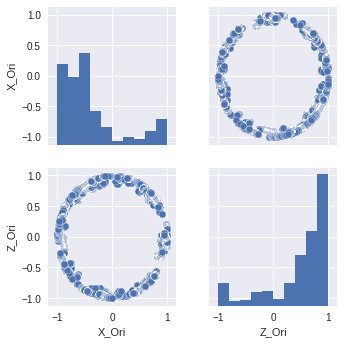

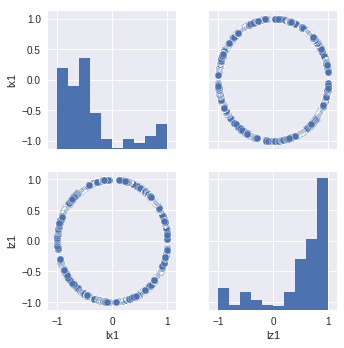

In [7]:
# plotting original X, Y and new vector
fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['X_Ori', 'Z_Ori'])

fig = plt.figure(figsize=(12,12))
sns.pairplot(dfV, vars=['lx1', 'lz1'])

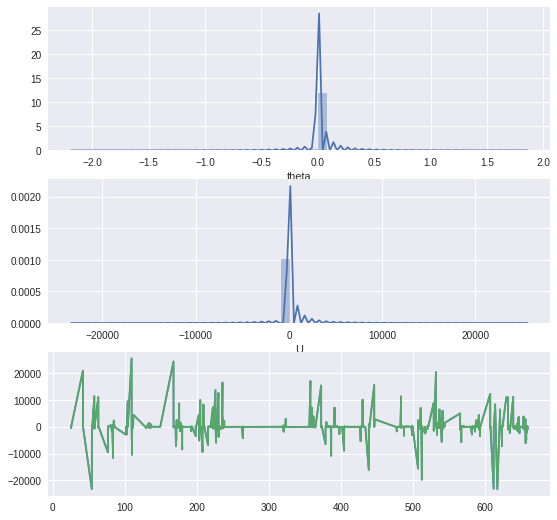

In [8]:
# U and theta distributions
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.distplot(dfV.theta, ax=ax1)
sns.distplot(dfV.U    , ax=ax2)
c2 = ax3.plot(dfV.Time, dfV.U)


## Filtering velocity values

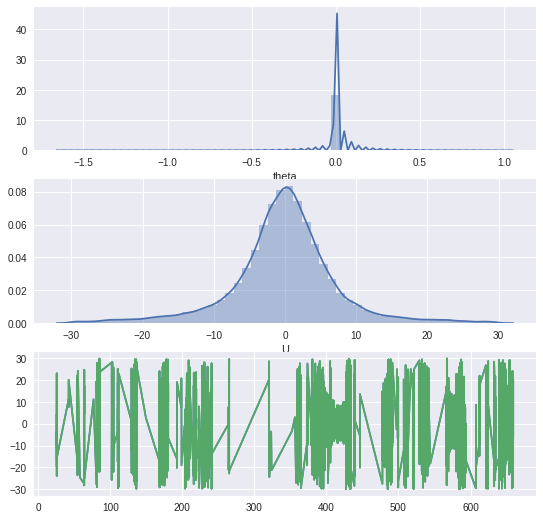

In [9]:
# U and theta distributions with limited velocity
vlim = 50
dfV = dfV[dfV['U'] < vlim]
dfV = dfV[dfV['U'] >-vlim]

# U and theta distributions
fig = plt.figure(figsize=(9,9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

sns.distplot(dfV.theta, ax=ax1)
sns.distplot(dfV.U    , ax=ax2)
c2 = ax3.plot(dfV.Time, dfV.U)

## Angular velocity analysis
Comparison of velocity logged per even with calculated velocit (substraction and correlation). Addtional smoothing of the data applied.

In [10]:
#smoothing the data
dfV['M']     = dfV['U'].rolling(window=200).mean()

# substraction
dfV['sub1']  = dfV.apply(lambda row: row.U - row.speed , axis=1)
dfV['sub2']  = dfV.apply(lambda row: row.M - row.speed , axis=1)

# correlation
dfV['corr']  = signal.correlate(dfV.speed, dfV.U, mode='same') / 128
dfV['corrM'] = signal.correlate(dfV.speed, dfV.M, mode='same') / 128

#dfV.dropna(inplace=True)oh

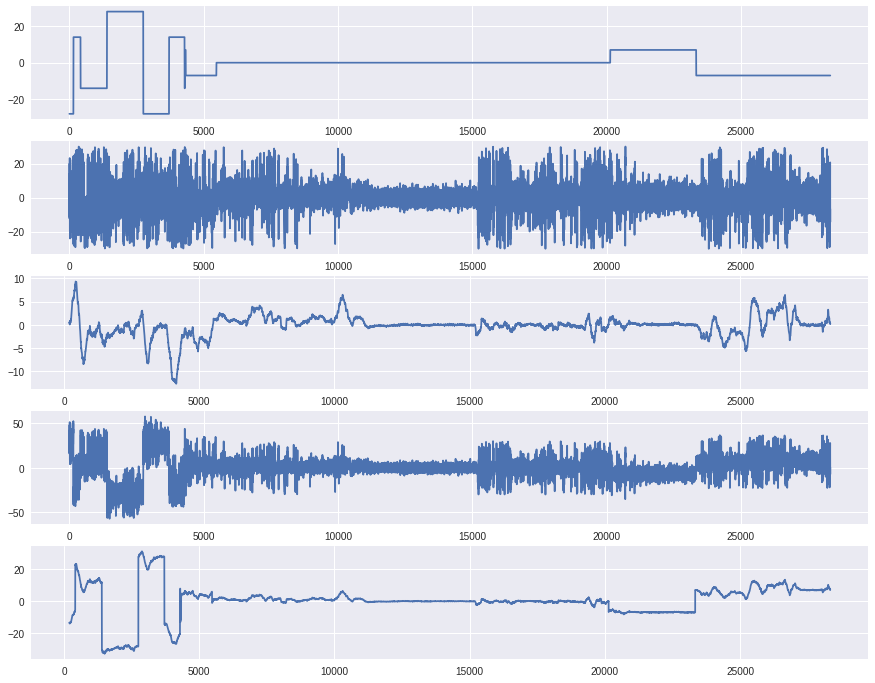

In [20]:
## Plotting
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

r = range(0, len(dfV))

c2 = ax1.plot(r, dfV.speed)
c1 = ax2.plot(r, dfV.U)
c4 = ax3.plot(r, dfV.M)
c3 = ax4.plot(r, dfV.sub1)
c5 = ax5.plot(r, dfV.sub2)

## Applying the method to all experiments

In [12]:
DF = {}

for i, x in enumerate(fname):
    DF[i] = pd.merge(event[i], df[i], on='Frame')

    #clearing data off useless variables
    DF[i].rename(columns={"Time_Ori":'Time'}, inplace=True)
    DF[i].drop({'Time_Pos', 'X_Pos', 'Y_Pos', 'Z_Pos', 'dX', 'dY', 'dZ',}, axis=1, inplace=True)


In [13]:
# calculating lenghts of VecX and VecZ and creation of shifted vectors
for i, x in enumerate(fname):
    DF[i] = DF[i].apply(decompose_vec_df, axis=1)
    DF[i]['V1'] = np.linalg.norm(np.array([DF[i].lx1, 0, DF[i].lz1]))

    # propagate the sign of a X, Z to new vector
    DF[i]['lx1'] = DF[i].apply(lambda row: row.lx1 * (row.X_Ori / np.absolute(row.X_Ori)), axis=1)
    DF[i]['lz1'] = DF[i].apply(lambda row: row.lz1 * (row.Z_Ori / np.absolute(row.Z_Ori)), axis=1)

    # normalize the data to unit vector form
    DF[i]['lx1'] = DF[i].apply(lambda row: row.lx1 / row.V1, axis=1)
    DF[i]['lz1'] = DF[i].apply(lambda row: row.lz1 / row.V1, axis=1)

    DF[i].dropna(inplace=True)


In [14]:
# calculatinig the angles between X axis and the vectors
for i, x in enumerate(fname):
    DF[i] = DF[i].apply(angle_orig, axis=1) # calculation between two vectors(does not include direction) -  theta
    DF[i] = DF[i].apply(angle_zero, axis=1) # calculation with origin

    DF[i]['theta1'] = DF[i].theta0.shift(1)
    DF[i]['theta']  = DF[i].apply(lambda row: row.theta0 - row.theta1, axis=1)
    DF[i].drop({'theta0','theta1'}, axis=1, inplace=True)


In [15]:
# angular velocity
for i, x in enumerate(fname):
    DF[i]['U']     = DF[i].apply(lambda row: np.degrees(row.theta)     / row.dTime, axis=1) #between two vectors velocity
    DF[i]['UOrig'] = DF[i].apply(lambda row: np.degrees(row.thetaOrig) / row.dTime, axis=1)
    DF[i].dropna(inplace=True)


In [16]:
# U and theta distributions with limited velocity
vlim = 30
for i, x in enumerate(fname):
    DF[i] = DF[i][DF[i]['U'] < vlim]
    DF[i] = DF[i][DF[i]['U'] >-vlim]


In [17]:
for i, x in enumerate(fname):
    # smoothing the data
    DF[i]['M']     = DF[i]['U'].rolling(window=100).mean()

    # substraction
    DF[i]['sub1']  = DF[i].apply(lambda row: row.U - row.speed , axis=1)
    DF[i]['sub2']  = DF[i].apply(lambda row: row.M - row.speed , axis=1)

    # correlation
    DF[i]['corr']  = signal.correlate(DF[i].speed, DF[i].U, mode='same') / 128
    DF[i]['corrM'] = signal.correlate(DF[i].speed, DF[i].M, mode='same') / 128


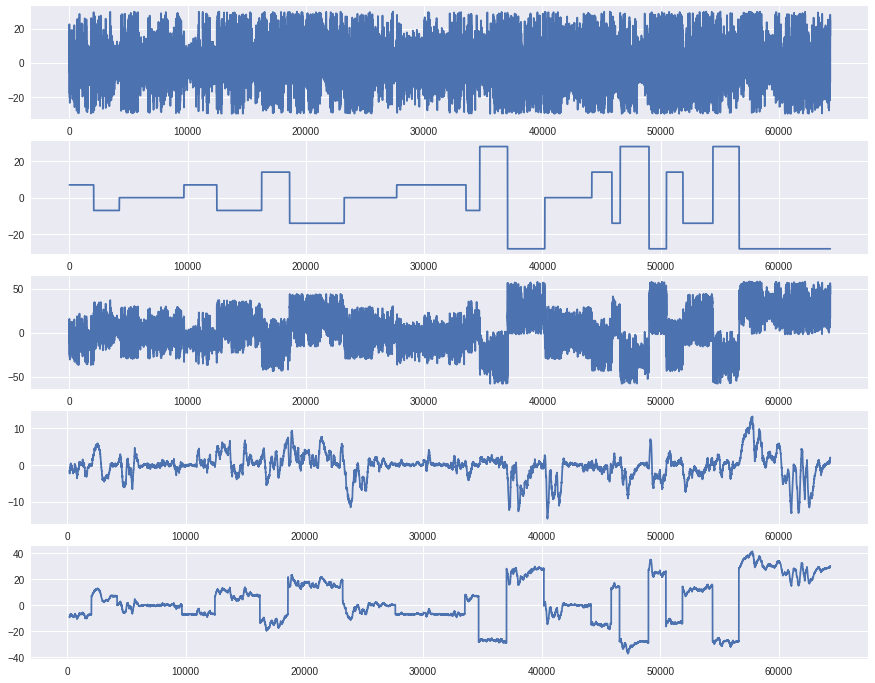

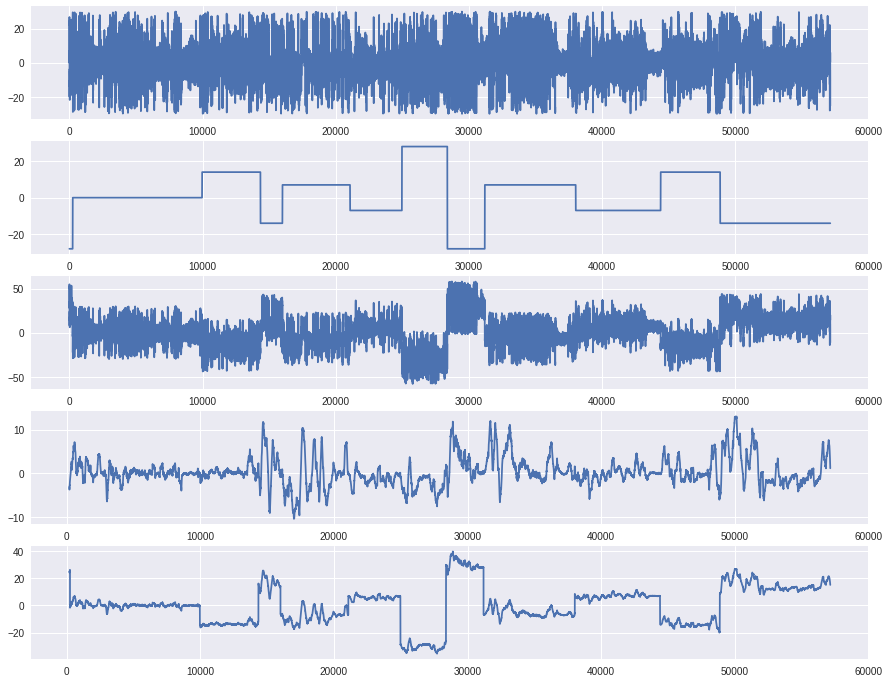

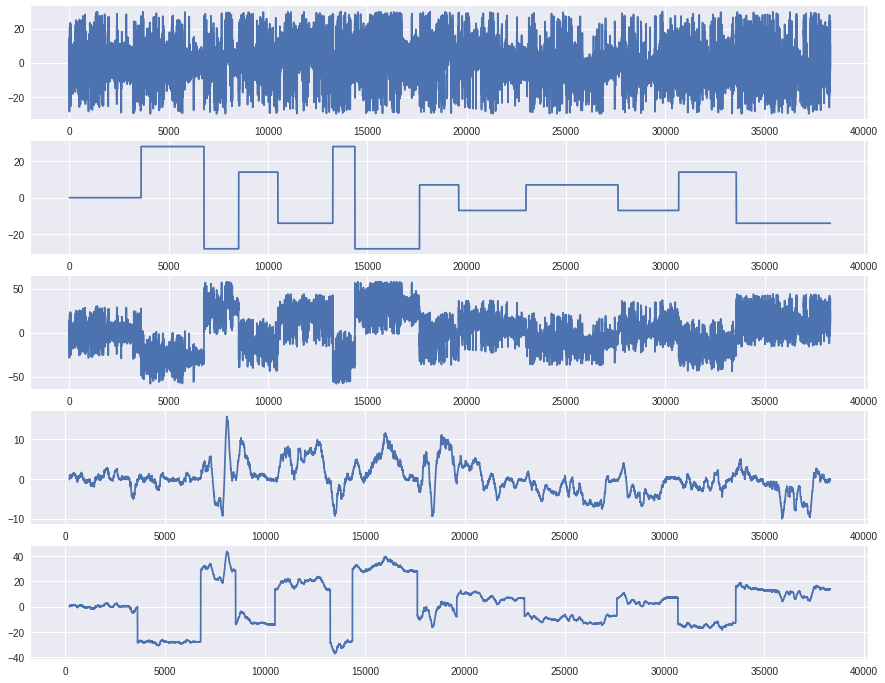

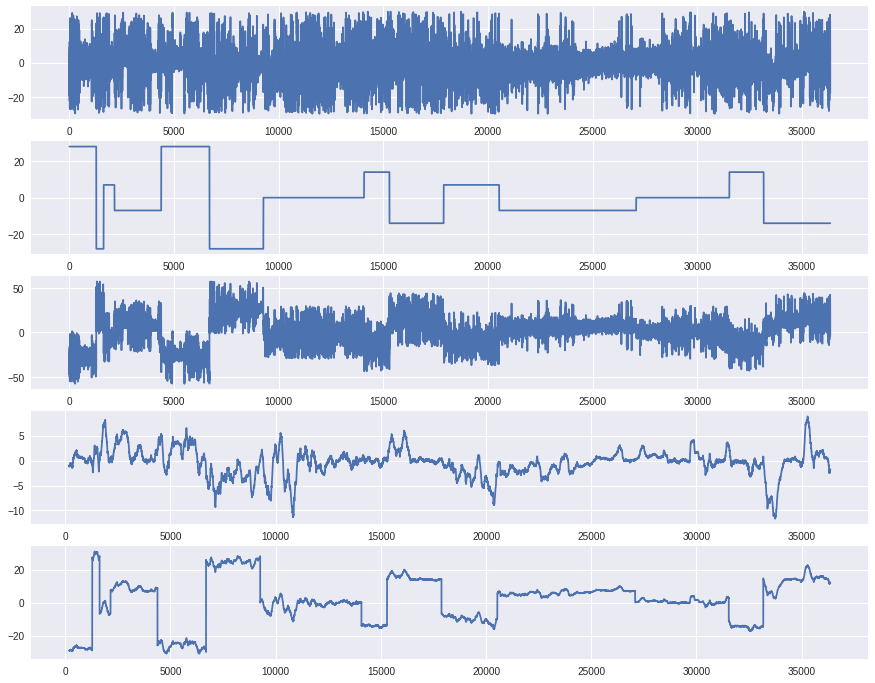

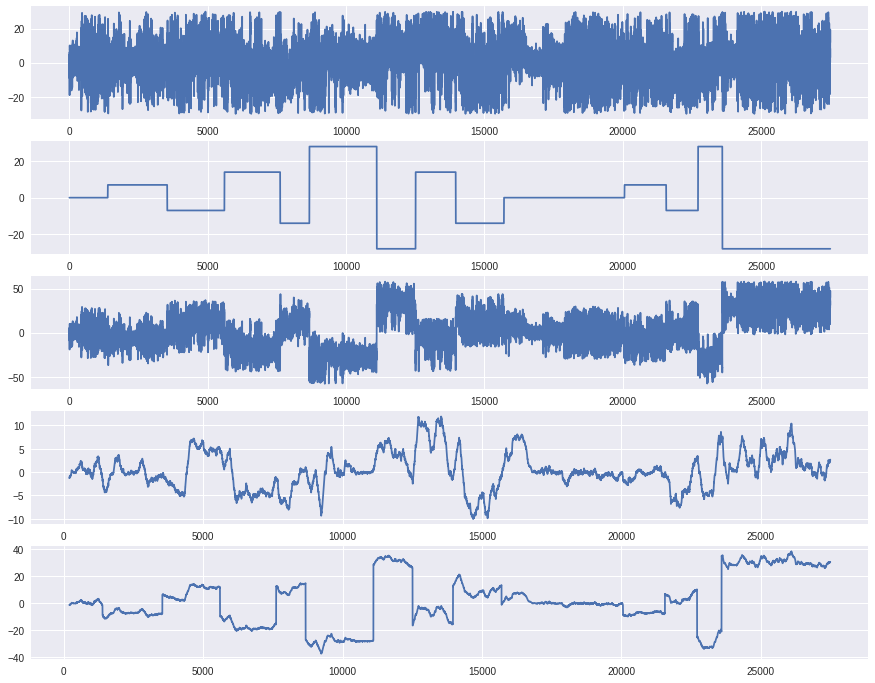

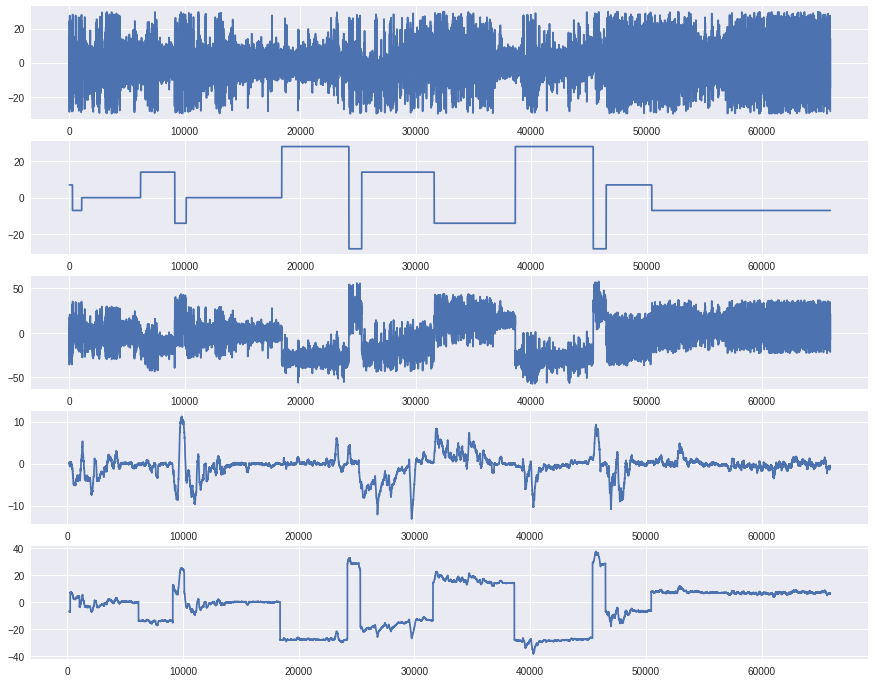

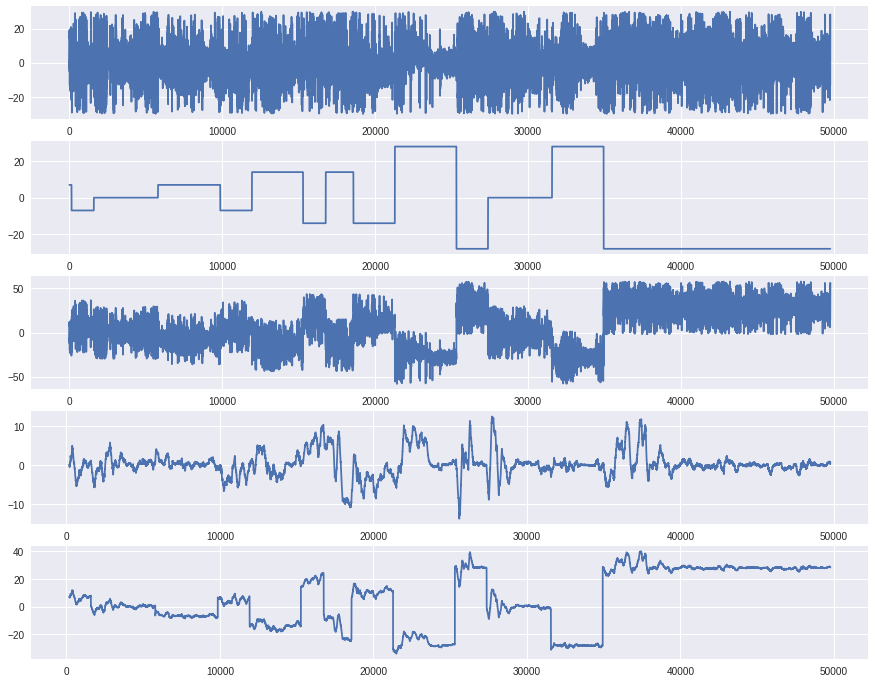

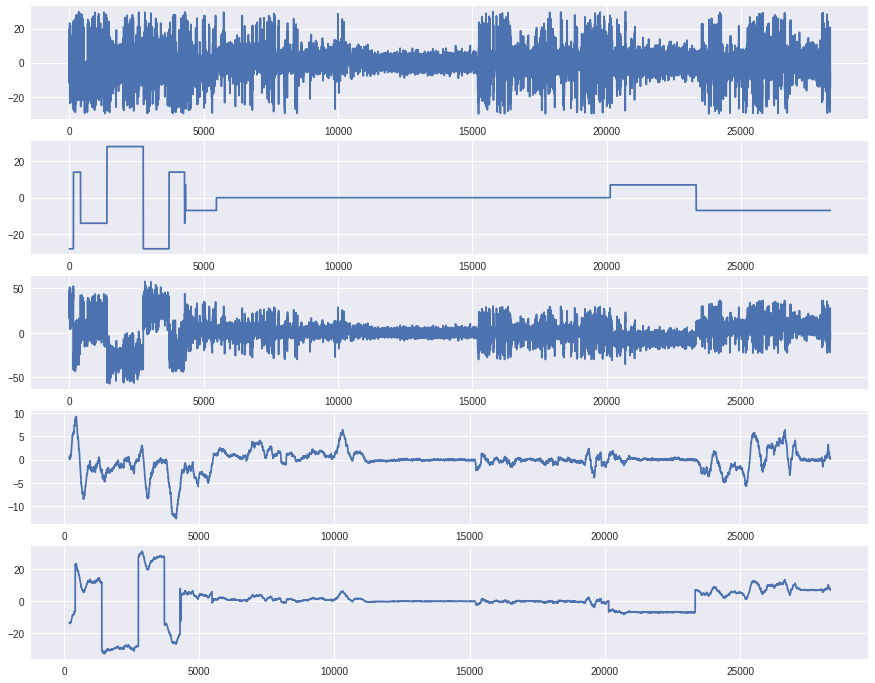

In [19]:
for i, x in enumerate(fname):
    ## Plotting
    fig = plt.figure(figsize=(15,12))
    ax1 = fig.add_subplot(511)
    ax2 = fig.add_subplot(512)
    ax3 = fig.add_subplot(513)
    ax4 = fig.add_subplot(514)
    ax5 = fig.add_subplot(515)

    r = range(0, len(DF[i]))

    c1 = ax1.plot(r, DF[i].U)
    c2 = ax2.plot(r, DF[i].speed)
    c3 = ax3.plot(r, DF[i].sub1)
    c4 = ax4.plot(r, DF[i].M)
    c5 = ax5.plot(r, DF[i].sub2)